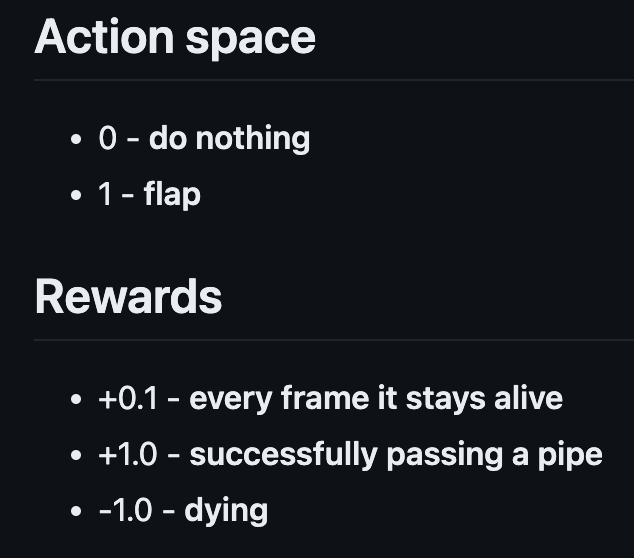

In [19]:
import flappy_bird_gymnasium
import gymnasium as gym
from collections import namedtuple, deque
import random
import torch.nn as nn
import torch as th
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from collections import defaultdict
import datetime
import math
import torch.nn.functional as F

In [20]:
env = gym.make("FlappyBird-v0", render_mode="human")

obs, _ = env.reset()

print(f"{env.observation_space=}")
print(f"{env.action_space}")

env.observation_space=Box(-inf, inf, (12,), float64)
Discrete(2)


In [21]:
env.reset()

(array([ 1.       ,  0.       ,  1.       ,  1.       ,  0.       ,
         1.       ,  1.       ,  0.       ,  1.       ,  0.4765625,
        -0.9      ,  0.5      ]),
 {'score': 0})

In [22]:
class ReplayMemory:

    def __init__(self, max_length, observation_space):
        self.index = 0
        self.size = 0
        self.max_length = max_length

        self.states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.actions = np.zeros((max_length), dtype=np.float32)
        self.rewards = np.zeros((max_length), dtype=np.float32)
        self.next_states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.dones = np.zeros((max_length), dtype=np.float32)

    def __len__(self):
        return self.size

    def update(self, state, action, reward, next_state, done):
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = done

        self.index = (self.index + 1) % self.max_length
        if self.size < self.max_length:
            self.size += 1

    def sample(self, batch_size):
        indexes = np.random.randint(0, self.size, size=batch_size)

        return self.states[indexes], self.actions[indexes], self.rewards[indexes], self.next_states[indexes], \
               self.dones[indexes]

In [23]:
class LinearNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim))
    def forward(self, x):
        return self.layers(x)

In [24]:
class Policy:
    def __init__(self,
                 observation_space,
                 action_space,
                 lr=3e-4,
                 gamma=0.9,
                 max_memory=10_000,
                 epsilon_init=0.5,
                 epsilon_decay=0.995,
                 epsilon_min=0.01,
                 epochs=1):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.memory = ReplayMemory(max_memory, observation_space.shape[0])
        self.action_space = action_space
        self.epochs = epochs

        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.dqn = LinearNetwork(observation_space.shape[0], action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

    def act(self, state):
        if np.random.random() < self.epsilon: #random action
            action = self.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(self.device)
                action = self.dqn.forward(state).argmax(dim=-1)
                action = action.cpu().numpy()

        return action

    def eps_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, new_state, done):
        self.memory.update(state, action, reward, new_state, done)

    def train(self, batch_size, save=False):
        if batch_size * 10 > self.memory.size:
            return

        for epoch in range(self.epochs):
            states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

            states = torch.as_tensor(states).to(self.device)
            actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
            rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
            next_states = torch.as_tensor(next_states).to(self.device)
            dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)

            q = self.dqn.forward(states).gather(-1, actions.long())

            with torch.no_grad():
                q2 = self.dqn.forward(next_states).max(dim=-1, keepdim=True)[0]

                target = (rewards + (1 - dones) * self.gamma *q2).to(self.device)

            loss = F.mse_loss(q, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [25]:
def train(agent, env, timesteps, batch_size):
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []
    episode = 0
    state, _ = env.reset()

    for timestep in range(1, timesteps + 1):
        action = agent.act(state)

        # выполняем действие
        next_state, reward, done, _,  info = env.step(action)

        # получаем обсервейшн
        agent.remember(state, action, reward, next_state, done)

        # обучаем агента
        agent.train(batch_size, False)

        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state, _ = env.reset()

        agent.eps_decay()

        if episode_returns:
            avg_returns.append(np.mean(episode_returns))

        total_reward *= 1 - done
        ratio = math.ceil(100 * timestep / timesteps)
        avg_return = avg_returns[-1] if avg_returns else np.nan

        # обновляем стейт
        state = next_state

        print(
            f"\r[{ratio:3d}%]",
            f"timestep = {timestep}/{timesteps}",
            f"episode = {episode:3d}",
            f"avg_return = {avg_return:10.4f}",
            f"eps = {agent.epsilon:.4f}",
            sep=", ",
            end="")

    print()
    return avg_returns

[100%], timestep = 100000/100000, episode = 990, avg_return =     9.0550, eps = 0.0034


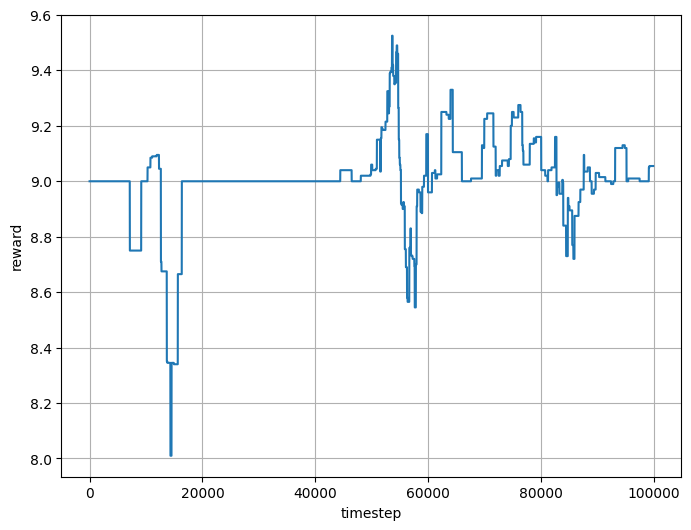

In [27]:
env_name = 'FlappyBird-v0'
env = gym.make(env_name)
OBS_SPACE = gym.spaces.Box(-np.inf, np.inf, shape=(12,))
ACT_SPACE = env.action_space

dqn_net = Policy(observation_space=OBS_SPACE,
                    action_space=ACT_SPACE,
                    lr=0.001,
                    gamma=0.99,
                    max_memory=1000000,
                    epsilon_init=0.5,
                    epsilon_decay=0.99995,
                    epsilon_min=0.001,
                    epochs=1)

results_dqn = train(dqn_net, env, 100000, 64)

plt.figure(figsize=(8,6))
plt.plot(results_dqn)
plt.xlabel('timestep')
plt.ylabel('reward')
plt.grid()
plt.show()